In [1]:
import sys
sys.path.append('../')
from config import *
from src.realtime_utils import *

In [2]:
from plotnine import *

In [9]:
dates = ['2023-12-07', '2024-02-08', '2024-04-11', '2024-06-13', '2024-08-15', '2024-10-06']

In [10]:
forecast_dates = dates[:-1]

In [11]:
dfs = []
for f in dates:
    ts = load_target_series('sari', f, age_group='00+')
    df = ts.pd_dataframe().reset_index()
    df['forecast_date'] = f
    dfs.append(df)

df = pd.concat(dfs)
df = df.rename(columns={'icosari-sari-DE': 'value'})

In [12]:
def load_nowcast_wide(date, location="DE", age_group="00+"):
    # Construct the file path
    file_path = f'../data/nowcasts/KIT-baseline/{f}-icosari-sari-KIT-baseline.csv'
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Filter based on location, age_group, and type
    df_filtered = df[
        (df['location'] == location) & 
        (df['age_group'] == age_group) & 
        (df['type'] == "quantile")
    ]
    
    # Pivot the dataframe: quantile values will become columns with "quantile_" as a prefix
    df_wide = df_filtered.pivot(
        index=['location', 'age_group', 'target_end_date', 'forecast_date', 'horizon'],  # Relevant index columns
        columns='quantile',  # Column to pivot on
        values='value'  # The column containing the values to pivot
    )
    
    # Rename columns to add "quantile_" prefix
    df_wide.columns = [f'quantile_{col}' for col in df_wide.columns]
    
    # Reset index to turn index columns back to normal columns (optional)
    df_wide = df_wide.reset_index()
    
    return df_wide

In [13]:
def load_forecast_wide(date, model="KIT-MeanEnsemble", location="DE", age_group="00+"):
    # Construct the file path
    file_path = f'../data/post-covid/submissions/{model}/{f}-icosari-sari-{model}.csv'
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Filter based on location, age_group, and type
    df_filtered = df[
        (df['location'] == location) & 
        (df['age_group'] == age_group) & 
        (df['type'] == "quantile")
    ]
    
    # Pivot the dataframe: quantile values will become columns with "quantile_" as a prefix
    df_wide = df_filtered.pivot(
        index=['location', 'age_group', 'target_end_date', 'forecast_date', 'horizon'],  # Relevant index columns
        columns='quantile',  # Column to pivot on
        values='value'  # The column containing the values to pivot
    )
    
    # Rename columns to add "quantile_" prefix
    df_wide.columns = [f'quantile_{col}' for col in df_wide.columns]
    
    # Reset index to turn index columns back to normal columns (optional)
    df_wide = df_wide.reset_index()
    
    return df_wide

In [14]:
nowcasts = []
for f in forecast_dates:
    df_temp = load_nowcast_wide(f)
    nowcasts.append(df_temp)
df_nowcast = pd.concat(nowcasts)

In [15]:
forecasts = []
for f in forecast_dates:
    df_temp = load_forecast_wide(f)
    forecasts.append(df_temp)
df_forecast = pd.concat(forecasts)

In [16]:
alphas = {"50%": 0.7, "95%": 0.4}

In [17]:
df = df[df.date >= '2023-06-01']

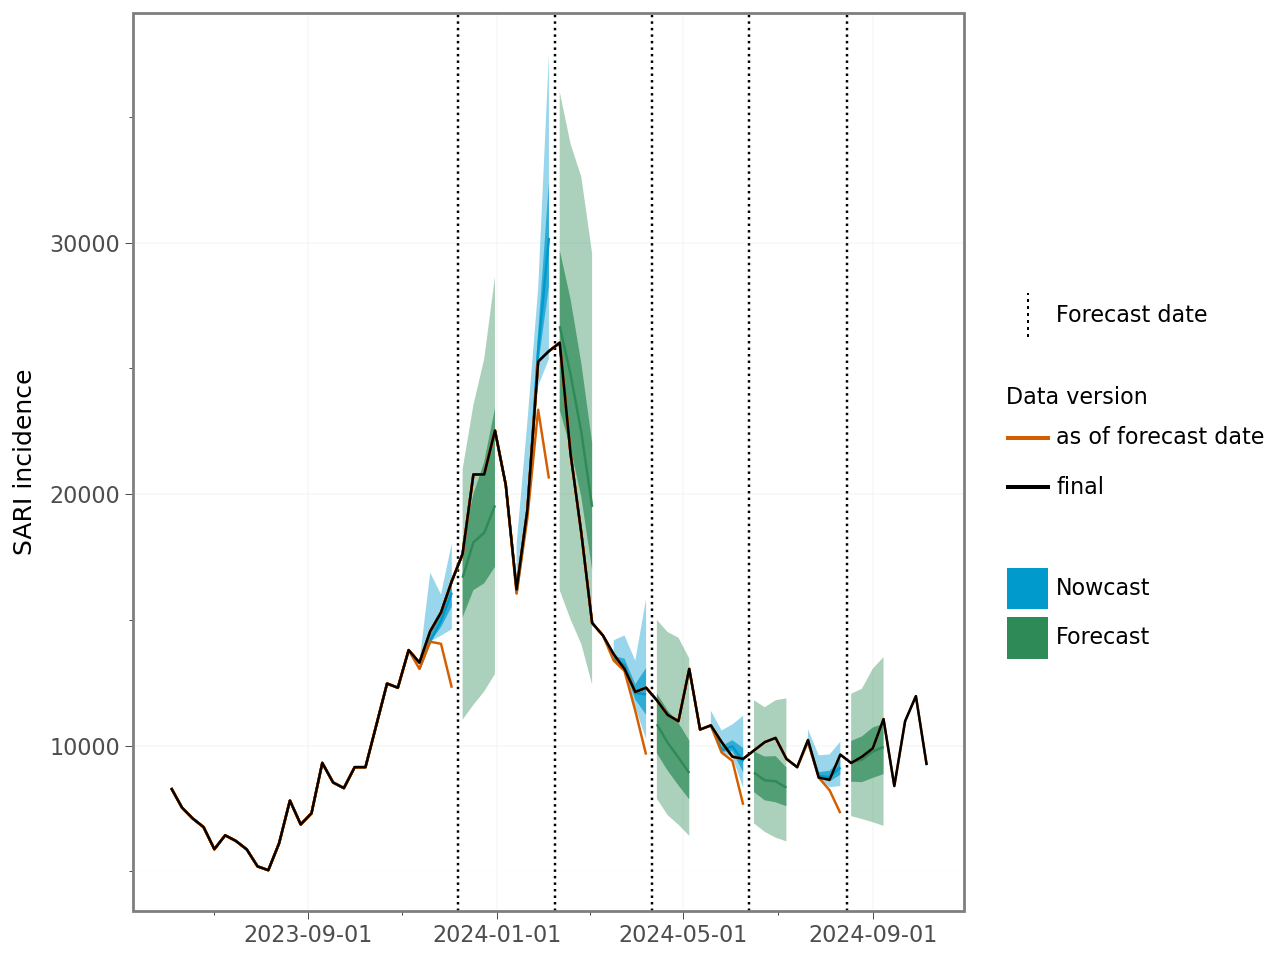

In [32]:
p = (ggplot(df) +
    geom_vline(
         data=pd.DataFrame({'date': [pd.Timestamp(f) for f in forecast_dates]}),
         mapping=aes(xintercept='date', linetype='"Forecast date"'),
         color="black"
     ) +
     geom_ribbon(
         data=df_nowcast,
         mapping=aes(x='target_end_date', ymin='quantile_0.025', ymax='quantile_0.975', group='forecast_date', alpha='"95%"', fill='"Nowcast"') # deepskyblue3
     ) +
     geom_ribbon(
         data=df_nowcast,
         mapping=aes(x='target_end_date', ymin='quantile_0.25', ymax='quantile_0.75', group='forecast_date', alpha='"50%"', fill='"Nowcast"')
     ) +
     geom_line(
         data=df_nowcast,
         mapping=aes(x='target_end_date', y='quantile_0.5', group='forecast_date'),
         color="#009ACD", linetype="solid"
     ) +
     
    geom_ribbon(
         data=df_forecast,
         mapping=aes(x='target_end_date', ymin='quantile_0.025', ymax='quantile_0.975', group='forecast_date', alpha='"95%"', fill='"Forecast"')
     ) +
     geom_ribbon(
         data=df_forecast,
         mapping=aes(x='target_end_date', ymin='quantile_0.25', ymax='quantile_0.75', group='forecast_date', alpha='"50%"', fill='"Forecast"')
     ) +
     geom_line(
         data=df_forecast,
         mapping=aes(x='target_end_date', y='quantile_0.5', group='forecast_date'),
         color="seagreen", linetype="solid"
     ) +
     geom_line(aes(x='date', y='value', group='forecast_date', color='"as of forecast date"')) +
     geom_line(data=df[df.forecast_date == '2024-10-06'], mapping=aes(x='date', y='value', color='"final"')) +
     theme_bw() +
     labs(x='', y='SARI incidence', linetype='') +
     scale_color_manual(name='\nData version', values={'as of forecast date': '#D55E00', 'final' : 'black'}) +
     scale_fill_manual(name=' ', values={'Forecast': 'seagreen', 'Nowcast': '#009ACD'}) +
     scale_linetype_manual(name=' ', values={'Forecast date': "dotted"}, guide=guide_legend(order=1)) +
     scale_alpha_manual(name="Forecasts with \nprediction intervals:", values=alphas, guide=None)+
     theme(
         legend_position="right",
         legend_title=element_text(size=8),
         legend_text=element_text(size=8),
         legend_key=element_blank(),
         #legend_key_size=0.65,
         axis_title_y=element_text(size=9),
         axis_text=element_text(size=8),
         axis_ticks=element_line(color="black", size=0.25),
         panel_grid_major=element_line(size=0.15),
         panel_grid_minor=element_line(size=0.1),
         #plot_margin=(1, 1.5, 0, 1.5),
         #legend_margin=5,
         #legend_box_spacing=0
     )  
)

p

In [33]:
p.save("../figures/forecast.pdf", width = 190.5, height = 90, units="mm", dpi=300)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 190.5 x 90.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/forecast.pdf
